# Моя реализация алгоритма линейной регрессии

Импортируем необходимые библиотеки для работы, тестирования итоговых результатов и их визуализации

In [171]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

### Данная модель принимает на вход следующие параметры:

  - n_iter - количество итераций алгоритма. По умолчанию: 100

  - learning_rate - коэффициент скорости обучения градиентного спуска. По умолчанию: 0.1

  - metric - метрика, рассчитывающаяся в процессе и в конце обучения модели. Поддерживаемые значения: 'mse', 'rmse', 'mae', 'mape', 'r2'. По умолчанию: None

  - reg - тип регуляризации. Поддерживаемые значения: 'l1' - для L1 регуляризации, 'l2' - для L2, 'elasticnet' - для комбинации L1 и L2 регуляризаций. По умолчанию: None

  - l1_coef - коэффициент регуляризации L1. По умолчанию: 0

  - l2_coef - коэффициент регуляризации L2. По умолчанию: 0

  - sgd_sample - размер выборки для обучения стохастического градиентного бустинга. Значения от 0 до 1 задают долю исходной выборки, а целые значения >1 - количество элементов исходной выборки, которое будет использоваться. По умолчанию: None

### MyLineReg поддерживает следующие методы:

- fit(X: pd.DataFrame(), y: pd.Series(), verbose: None) - обучает модель на полученных данных. Доступна встроенная регуляризация трех типов, параллельный расчет одной из пяти обозначенных метрик, вывод лога компиляции и стохастический градиентный спуск для больших исходных данных.

- get_coef() - возвращает коэффициенты обученной модели

- predict(X) - возвращает предсказанные на основе X значения y

- get_best_score() - возвращает заданную при инициализации метрику, рассчитанную для обученной модели

In [154]:
class MyLineReg():
  def __init__(self, n_iter=100, learning_rate=0.1, metric=None, reg=None, l1_coef=0, l2_coef=0, sgd_sample=None, random_state=42):
    self.n_iter = n_iter
    self.learning_rate = learning_rate
    self.metric = metric
    self.reg = reg
    self.l1_coef = l1_coef
    self.l2_coef = l2_coef
    self.sgd_sample = sgd_sample
    self.random_state = random_state

  def __str__(self):
    return f'MyLineReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate}'

  def fit(self, X: pd.DataFrame(), y: pd.Series(), verbose=False):
    np.random.seed(self.random_state)
    random.seed(self.random_state)

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # создаем фиктивную фичу
    X = pd.concat([pd.DataFrame(np.ones(X.shape[0]).T), X], axis=1)
    m = X.shape[1]
    self.X = X
    self.y = y

    if self.sgd_sample:
      if self.sgd_sample<1:
        n = int(np.round(len(self.y)*self.sgd_sample))
      else:
        n = self.sgd_sample
    else:
      n = len(y)

    # создаем веса
    weights = np.ones(X.shape[1])

    #
    for iter in range(1, self.n_iter+1):

      if self.sgd_sample:
        sample_rows_idx = random.sample(range(X.shape[0]), n)
        X_sample = self.X.iloc[sample_rows_idx, :].reset_index(drop=True)
        y_sample = self.y.iloc[sample_rows_idx].reset_index(drop=True)
      else:
        X_sample = self.X
        y_sample = self.y

      y_pred = np.dot(X_sample, weights)
      y_pred_full = np.dot(self.X, weights)

      if self.reg=='l1':
        MSE = np.sum((y_pred_full - self.y)**2)/len(self.y) + np.sum(self.l1_coef*np.abs(weights))
        MSE_gradient = (np.dot(y_pred-y_sample, X_sample))*2/n + (np.sign(weights))*self.l1_coef
      elif self.reg=='l2':
        MSE = np.sum((y_pred_full - self.y)**2)/len(self.y) + np.sum(self.l2_coef*(weights)**2)
        MSE_gradient = (np.dot(y_pred-y_sample, X_sample))*2/n + 2*(weights)*self.l2_coef
      elif self.reg=='elasticnet':
        MSE = np.sum((y_pred_full - self.y)**2)/len(self.y) + np.sum(self.l2_coef*(weights)**2) + np.sum(self.l1_coef*np.abs(weights))
        MSE_gradient = (np.dot(y_pred-y_sample, X_sample))*2/n  + 2*(weights)*self.l2_coef + (np.sign(weights))*self.l1_coef
      else:
        MSE = np.sum((y_pred_full - self.y)**2)/len(self.y)
        MSE_gradient = np.dot(y_pred-y_sample, X_sample)*2/n

      if callable(self.learning_rate):
          learning_rate = self.learning_rate(iter)
      else:
          learning_rate = self.learning_rate
      weights -= MSE_gradient*learning_rate

      if self.metric=='mae':
        self.metric_value = np.sum(np.abs(y_pred_full-self.y))/len(self.y)
      elif self.metric=='mse':
        self.metric_value = np.sum((y_pred_full-self.y)**2)/len(self.y)
      elif self.metric=='rmse':
        self.metric_value = (np.sum((y_pred_full-self.y)**2)/len(self.y))**0.5
      elif self.metric=='mape':
        self.metric_value = np.sum(np.abs((y_pred_full-self.y)/y))/len(self.y)*100
      elif self.metric=='r2':
        self.metric_value = 1 - np.sum((y_pred_full - self.y)**2)/np.sum((self.y - np.mean(self.y))**2)
      else:
        self.metric_value = f'metric {self.metric} is not supported'

      if verbose:
        if iter==0:
          if not self.metric:
            print(f'start | loss: {MSE}')
          else:
            print(f'start | loss: {MSE} | {self.metric}: {self.metric_value}')

        elif iter%verbose==0:
          if not self.metric:
            print(f'{iter} | loss: {MSE}')
          else:
            print(f'{iter} | loss: {MSE} | {self.metric}: {self.metric_value}')

    self.weights = weights

    y_pred = np.dot(X_sample, weights)
    y_pred_full = np.dot(self.X, weights)

    if self.metric=='mae':
        self.metric_value = np.sum(np.abs(y_pred_full-self.y))/len(self.y)
    elif self.metric=='mse':
        self.metric_value = np.sum((y_pred_full-self.y)**2)/len(self.y)
    elif self.metric=='rmse':
        self.metric_value = (np.sum((y_pred_full-self.y)**2)/len(self.y))**0.5
    elif self.metric=='mape':
        self.metric_value = np.sum(np.abs((y_pred_full-self.y)/y))/len(self.y)*100
    elif self.metric=='r2':
        self.metric_value = 1 - np.sum((y_pred_full - self.y)**2)/np.sum((self.y - np.mean(self.y))**2)
    else:
        self.metric_value = f'metric {self.metric} is not supported'

  def get_coef(self):
    return self.weights[1:]

  def predict(self, X):
    X = X.reset_index(drop=True)
    X = pd.concat([pd.DataFrame(np.ones(X.shape[0]).T), X], axis=1)
    return np.dot(X, self.weights)

  def get_best_score(self):
    return self.metric_value

### Обучим нашу модель на данных и сравним ее точность с встроенной в sklearn

Генерируем данные с помощью функции make_regression из sklearn и делим их на train и test

In [155]:
X, y = make_regression(n_samples=400, n_features=14, n_informative=5, noise=5, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

Обучаем построенную модель на train выборке и считаем среднюю абсолютную ошибку в процентах

In [175]:
model = MyLineReg()
model.fit(X_train, y_train, verbose=10)
y_pred = model.predict(X_test)

mean_absolute_percentage_error(y_test, y_pred)

10 | loss: 346.1929327104064
20 | loss: 43.51785553425382
30 | loss: 27.077908592131887
40 | loss: 26.064167071841023
50 | loss: 26.000030698627732
60 | loss: 25.995946933235803
70 | loss: 25.99568643732012
80 | loss: 25.99566981151126
90 | loss: 25.9956687501938
100 | loss: 25.995668682439465


0.11519140135797028

Обучаем модель из sklearn и считаем ошибку для нее

In [176]:
model_sk = LinearRegression()
model_sk.fit(X_train, y_train)
y_pred_sk = model_sk.predict(X_test)

mean_absolute_percentage_error(y_test, y_pred_sk)

0.11519102642655868

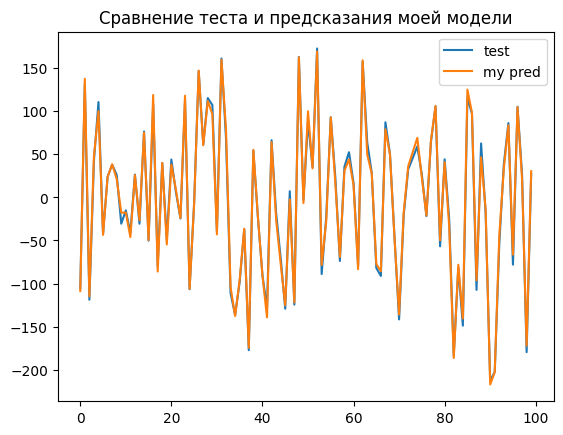

In [182]:
plt.title('Сравнение теста и предсказания моей модели')
plt.plot(y_test.reset_index(drop=True), label='test')
plt.plot(y_pred, label='my pred')
plt.legend()
plt.show()

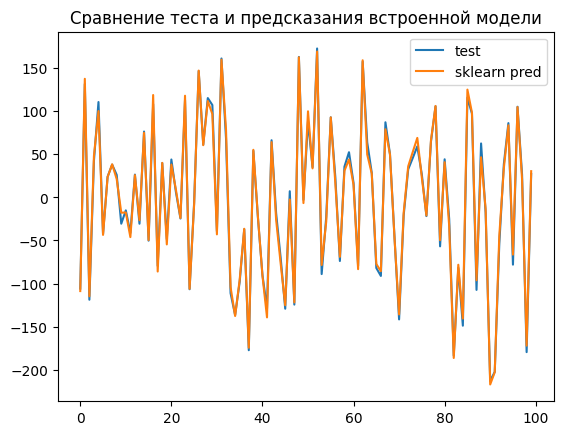

In [184]:
plt.title('Сравнение теста и предсказания встроенной модели')
plt.plot(y_test.reset_index(drop=True), label='test')
plt.plot(y_pred_sk, label='sklearn pred')
plt.legend()
plt.show()

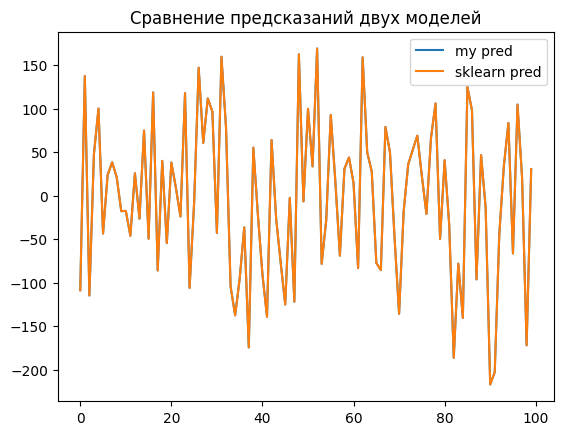

In [185]:
plt.title('Сравнение предсказаний двух моделей')
plt.plot(y_pred, label='my pred')
plt.plot(y_pred_sk, label='sklearn pred')
plt.legend()
plt.show()

Как видно из рассчитанных ошибок моделей и визуального сравнения результатов, построенная мной модель демонстрирует такую же точность до одной миллионной процента и показывает практически идентичные результаты, при этом поддерживая больший диапазон возможностей, чем встроенная в sklearn, включая регуляризацию и стохастический градиентный спуск. Исходя из перечисленного, я считаю, что данная реализация модели линейной регрессии успешна.